# Netherlands Neurogenetics Database
Author: Nienke Mekkes <br>
Date: 21-Sep-2022. <br>
Correspond: n.j.mekkes@umcg.nl <br>

## Script: clinical history labeled training data: cleaning & exploration
Objectives: load and clean training data, do some basic data exploration


### Input files:
- excel file with labeled training data

### Output:
- excel file with cleaned labeled training data 
- pickle file with cleaned labeled training data
- folder with figures with basic data explorations


#### Minimal requirements

In [1]:
%matplotlib inline

In [5]:
# %pip install pandas
# %pip install openpyxl
# %pip install seaborn
# %pip install pywaffle


#### Imports

In [3]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pywaffle import Waffle
from datetime import date


In [4]:
pd.__version__

'1.5.3'

#### Paths (user input required)

In [5]:
path_to_training_data = "/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/input_data/Final_Labeling_300_testcasusen_inclusief_pilots_Megan.xlsx"
save_path_files = "/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/training_data"
save_path_figures = "/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/figures_on_input_data"

In [6]:
if not os.path.exists(save_path_figures):
    print('Creating figure folder....\n')
    os.makedirs(save_path_figures)
    
if not os.path.exists(save_path_files):
    print('Creating output folder....')
    os.makedirs(save_path_files)

### Loading data

Training data comes in the form of an excel file with a tab per donor. <br>
Merge all Excel sheets together with concat, keeping the sheet names. <br>
The sheet names are the patient identifiers. <br>
Note, empty sheets (== donors without clinical history) are ignored by concat <br>

We also load a file with general informaiton about each donor, so we can add main diagnosis information <br>

In [7]:
## Takes some time, so run only once. Rest of script functions on data copy.
pd_df = pd.read_excel(path_to_training_data, engine='openpyxl', index_col=[0], sheet_name=None)
concat_training_data = pd.concat(pd_df, axis=0, ignore_index=True)


In [8]:
training_data = concat_training_data.copy()

## some attributes have very long names, these are shortened to prevent saving error 
training_data = training_data.rename(columns={"Hyperreflexia_and_other_reflexes":"Hyperreflexia_and_oth_reflexes",
                                              "Unspecified_disturbed_gait_patterns": "Unspecified_disturbed_gait_patt",
                                              "Fatique": "Fatigue",
                                              "Lack_of_planning_organisation_overview":"Lack_of_planning_organis_overv"})

print('Training data has', training_data.shape[0], 'sentences and ', training_data.shape[1], 'columns.' \
' Non-attribute columns are:')
non_attribute_columns = ['NBB_nr','Year_Sentence_nr','Sentence']
for i in non_attribute_columns: print(i)

# print(training_data.columns)

Training data has 19055 sentences and  93 columns. Non-attribute columns are:
NBB_nr
Year_Sentence_nr
Sentence


In [7]:
print('Before combining donors, training data has ', len(pd_df.keys()), 'unique NBB identifiers.')
print('After combining donors, training data has ',len(training_data['NBB_nr'].unique()),'unique NBB identifiers.')
before_concat = list(pd_df.keys())
after_concat = list(training_data['NBB_nr'].unique())

print('Donor files without clinical history are:',list(np.setdiff1d(before_concat,after_concat)))


Before combining donors, training data has  297 unique NBB identifiers.
After combining donors, training data has  293 unique NBB identifiers.
Donor files without clinical history are: ['NBB 2002-069', 'NBB 2003-009', 'NBB 2016-095', 'NBB 2018-121']


### Cleaning part 1
-Remove NaN sentences (5) <br>
-Remove sentences that are just a year (63) <br>
-Make sure that all values are a boolean of either 1 or 0. <br>

In [8]:
print('Before first round of cleaning, we have ',training_data.shape[0],'sentences.')

## remove NaN
training_data = training_data[training_data['Sentence'].notna()]

## removing (year) sentences
year = '\(\d+\)$'
training_data = training_data[lambda x: ~x['Sentence'].str.match(year)]

## Shows the unique values in the 90 columns 
print('All values present in training data: ',
      pd.unique(training_data.loc[:,[i for i in list(training_data.columns) if i not in non_attribute_columns]].values.ravel('K')))

training_data = training_data.replace("TRUE ", True)
training_data = training_data.replace("TRUE", True)
training_data = training_data.replace("True", True)
training_data = training_data.replace('False', False)
training_data = training_data.replace(True, 1)
training_data = training_data.replace(False, 0)
print('All values present in training data after conversion: ',
      pd.unique(training_data.iloc[:, 3:93].values.ravel('K')))

print('After first round of cleaning, we have ',training_data.shape[0],'sentences.')

Before first round of cleaning, we have  19055 sentences.
All values present in training data:  [False True 'False' 'TRUE ']
All values present in training data after conversion:  [0 1]
After first round of cleaning, we have  18987 sentences.


### Cleaning part 2
-Add non_attribute columns with Sentence length, number of scored attributes <br>
-Remove sentences with more than 8 attributes <br>
-Remove sentences with fewer than 6 characters <br>

In [9]:
training_data = training_data[training_data.loc[:,[i for i in list(training_data.columns) if i not in non_attribute_columns]].sum(axis=1) < 9]
training_data = training_data[training_data.Sentence.str.len() >= 6]
training_data.loc[:,[i for i in list(training_data.columns) if i not in non_attribute_columns]].astype(int)
# training_data =training_data[training_data['sentence_length'] <= 200]
print('After second round of cleaning, we have ',training_data.shape[0],'sentences.')

After second round of cleaning, we have  18917 sentences.


In [10]:
training_data.head()

,NBB_nr,Year_Sentence_nr,Sentence,Muscular_Weakness,Spasticity,Hyperreflexia_and_oth_reflexes,Frontal_release_signs,Fasciculations,Positive_sensory_symptoms,Negative_sensory_symptoms,...,Orthostatic_hypotension,Headache_migraine,Fatigue,Declined_deteriorated_health,Cachexia,Weight_loss,Reduces_oral_intake,Help_in_ADL,Day_care,Admission_to_nursing_home
0,NBB 1990-048,Past_sentence_0,Past: The patient was known to have atrial fib...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NBB 1990-048,Past_sentence_1,The patient was known to have hypertension and...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NBB 1990-048,1979_sentence_0,1979: She got a total hip,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NBB 1990-048,1979_sentence_1,At age 76 the first demential symptomes appeared,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NBB 1990-048,1979_sentence_2,After the death of her husband homesituation w...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### additional sentences for relabeling

In [11]:
training_data_relabel = training_data[training_data.Sentence.str.len() >= 20]
training_data_relabel = training_data_relabel.sample(n=1900, replace=False)
training_data_relabel

# since we cleaned up the training sentence file nicely, lets save it inbetween. this will be used to split the data.
training_data_relabel.to_excel(f"{save_path_files}/training_data_relabel.xlsx")
training_data_relabel.to_pickle(f"{save_path_files}/training_data_relabel.pkl") 

#### Should not be in final code, but this block creates supp. table 4


In [12]:
comma_df = training_data#.drop(['sum_true','sentence_length'], axis=1)
path_to_attribute_grouping = "/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/input_data/Clinical History - attributes grouping in categories - metadata.xlsx"
attribute_grouping = pd.read_excel(path_to_attribute_grouping, engine='openpyxl', index_col=[0], sheet_name='90 parameters')
correct_names = {}
for attr, real_name in zip(attribute_grouping.index, attribute_grouping["Attribute"]):
    if not isinstance(real_name, float):
        correct_names[real_name] = attr
# print(correct_names)
comma_df = comma_df.rename(correct_names,axis=1)
comma_df.loc[:, 'Muscular weakness':'Admission to nursing home'] = comma_df.loc[:, 'Muscular weakness':'Admission to nursing home'].replace(0, np.nan)  
comma_df.loc[:, 'Muscular weakness':'Admission to nursing home'] = comma_df.loc[:, 'Muscular weakness':'Admission to nursing home'].replace(1, pd.Series(comma_df.columns, comma_df.columns))
comma_df['Attribute(s)'] = comma_df.loc[:, 'Muscular weakness':'Admission to nursing home'].apply(lambda x: ','.join(x[x.notnull()]), axis = 1)
comma_df = comma_df[['NBB_nr','Sentence','Attribute(s)']]
display(comma_df.head(20))
comma_df.to_excel(f"{save_path_files}/sup4_chrono{date.today()}.xlsx")

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/input_data/Clinical History - attributes grouping in categories - metadata.xlsx'

#### Save as cleaned training data

In [13]:
# since we cleaned up the training sentence file nicely, lets save it inbetween. this will be used to split the data.
training_data.to_excel(f"{save_path_files}/cleaned_training_data.xlsx")
training_data.to_pickle(f"{save_path_files}/cleaned_training_data.pkl") 

In [14]:
## dotplot

In [21]:
pd.set_option('display.max_rows', 90)
frequency = training_data.copy()
frequency = frequency.iloc[:, -90:].sum()
print(frequency.sort_values())
# frequency

Fasciculations                       7
Head_turning_sign                    8
Loss_of_sympathy_empathy             9
Vivid_dreaming                      12
Olfactory_gustatory_dysfunction     17
Unspecified_disturbed_gait_patt     18
Facade_behavior                     25
Cachexia                            27
Frontal_release_signs               27
Day_night_rhythm_disturbances       30
Confabulations                      30
Orthostatic_hypotension             31
Vertigo                             35
Hyperorality                        37
Executive_function_disorder         41
Delusions                           41
Psychiatric_admissions              41
Nystagmus                           41
Mania                               42
Stress                              45
Suicidal_ideation                   47
Wandering                           50
Amnesia                             51
Paranoia_suspiciousness             53
Psychosis                           55
Apathy_inertia           

### DATA EXPLORATION (optional)
#### How long are our training sentences?

In [22]:
df = training_data_relabel

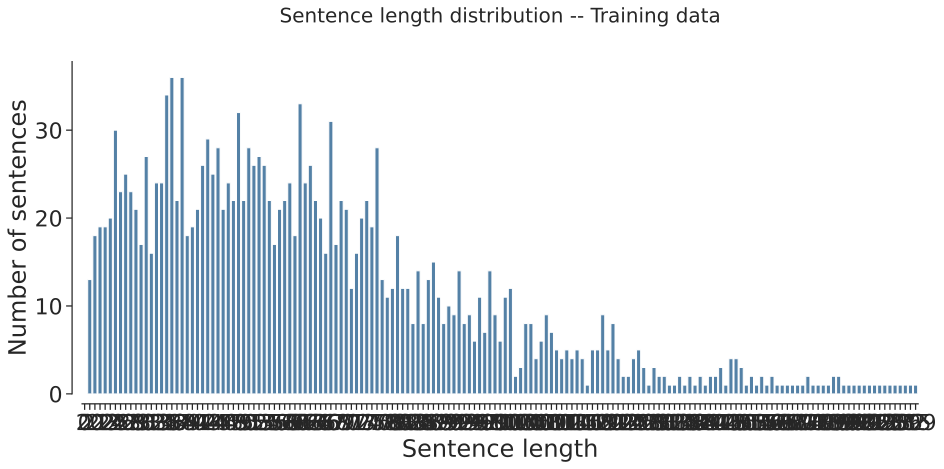

In [22]:
df["sum_true"] = df.loc[:,[i for i in list(df.columns) if i not in non_attribute_columns]].sum(axis=1)
df['sentence_length'] = df.Sentence.str.len()

%config InlineBackend.figure_format = 'svg'
sns.set(rc={'figure.figsize':(15,6)},font_scale = 2) #
sns.set_palette("pastel")
sns.set_style("ticks")

## get the frequency of the previously created column sentence_length
length_distribution = pd.DataFrame(df['sentence_length'].value_counts())
length_distribution['x'] = length_distribution.index
length_distribution.columns = ['nr_sentences','sentence_length']
zero_row = {'nr_sentences':0, 'sentence_length':0}
# length_distribution = length_distribution.append(zero_row, ignore_index=True)
length_distribution = pd.concat([length_distribution, pd.DataFrame.from_records([zero_row])],
                                ignore_index=True)
length_distribution = length_distribution.sort_values(by=['sentence_length'])

## plot and save
lh = sns.barplot(x="sentence_length", y="nr_sentences", data=length_distribution,color='steelblue')
lh.set(xlabel="Sentence length", ylabel="Number of sentences")
plt.title("Sentence length distribution -- Training data", y=1.1, fontsize = 20)
plt.xticks(rotation=90)
for ind, label in enumerate(lh.get_xticklabels()):
    if ind == 0:
        label.set_visible(True)
    elif ind % 10 == 0: 
        label.set_visible(True)
    else:
        label.set_visible(False)

sns.despine(offset=10, trim=False)
lh.spines["right"].set_color("none")
lh.spines["top"].set_color("none")

# plt.savefig(save_path_figures + "/training_data_sentence_length_distribution_{}.png".format(date.today()),
#             dpi=600, bbox_inches="tight")
# plt.savefig(save_path_figures + "/training_data_sentence_length_distribution_{}.pdf".format(date.today()),
#             dpi=600, bbox_inches="tight")
# plt.show()
# plt.close()

### How many sentences have how many attributes?
We expect that most sentences have no attribute, many sentences will have a single attribute, and a high amount of attributes for a single sentence is unlikely

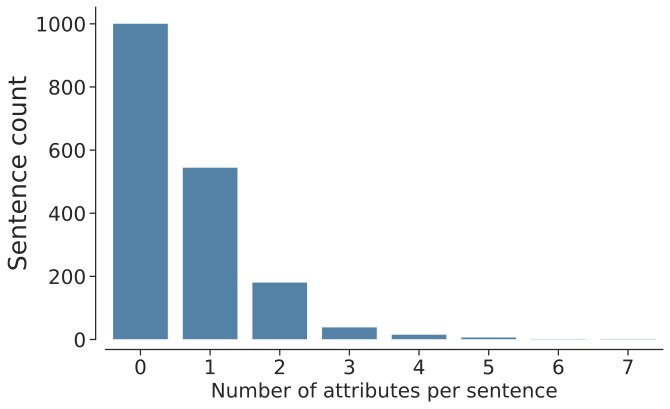

In [23]:

## get the frequency of the previously created column counting attributes per sentence
attribute_distribution = pd.DataFrame(df['sum_true'].value_counts())
attribute_distribution['nr_attributes'] = attribute_distribution.index
attribute_distribution.columns = ['nr_sentences','nr_attributes']


fig, ax = plt.subplots(figsize=(10,6))   
ax =  sns.barplot(x="nr_attributes", y="nr_sentences", data=attribute_distribution,color = 'steelblue')
sns.despine(offset=10, trim=False)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.set_xlabel("Number of attributes per sentence",fontsize=20)
ax.set_ylabel("Sentence count",fontsize=25)
ax.tick_params(labelsize=20)
# plt.savefig(save_path_figures + "/training_data_sentence_att_{}.pdf".format(date.today()),
#             bbox_inches="tight",dpi=600)
# plt.savefig(save_path_figures + "/training_data_sentence_att_{}.png".format(date.today()),
#             bbox_inches="tight",dpi=600)
# plt.show()

##### More intuitive is to plot as a waffle:

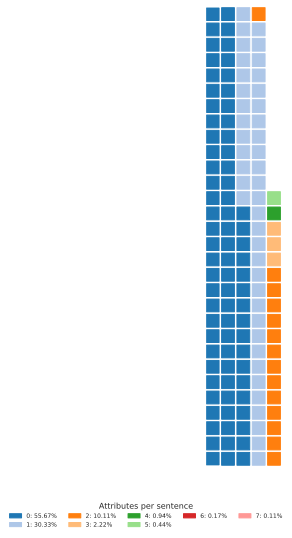

In [25]:
attribute_distribution['proportion'] = round(attribute_distribution['nr_sentences']/attribute_distribution['nr_sentences'].sum()*100,2)
palette = sns.color_palette("tab20")[0:8]
attribute_distribution['legend'] = attribute_distribution['nr_attributes'].astype(str) +': ' + attribute_distribution['proportion'].astype(str) + '%'
test = pd.Series(attribute_distribution.nr_sentences.values,index=attribute_distribution.nr_attributes).to_dict()

fig = plt.figure(
    FigureClass=Waffle, 
    rows=30, 
    values=list(attribute_distribution.nr_sentences/13),
    colors = palette,
    figsize=(10, 8),
        legend={'labels':list(attribute_distribution.legend),
            'loc': 'upper right', 'bbox_to_anchor': (1.1, -0.07), 
            'ncol': 5, 
            'framealpha': 0,
            'title':'Attributes per sentence',
            'title_fontsize':8,
            'fontsize': 6
               }    
)
# plt.savefig(save_path_figures + "/training_data_waffle_sentence_att_{}.pdf".format(date.today()),
#             bbox_inches="tight",dpi=600)
# plt.savefig(save_path_figures + "/training_data_waffle_sentence_att_{}.png".format(date.today()),
#             bbox_inches="tight",dpi=600)
# plt.show()


### What is the relationship between sentence length and number of attributes?
We expect that longer sentences have more attributes

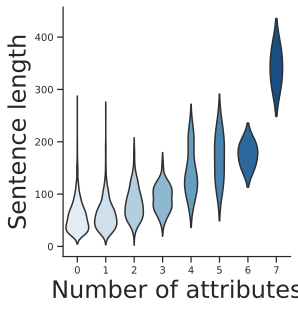

In [26]:
g = sns.catplot(x='sum_true', y='sentence_length', data=df,kind="violin",inner=None, palette='Blues')
plt.xlabel("Number of attributes")
plt.ylabel("Sentence length")
plt.tick_params(labelsize=10)
# plt.savefig(save_path_figures + "/training_data_violin_sentence_length_attributes_{}.png".format(date.today()),
#             bbox_inches="tight",dpi=600)
# plt.savefig(save_path_figures + "/training_data_violin_sentence_length_attributes_{}.pdf".format(date.today()),
#             bbox_inches="tight",dpi=600)
# plt.show()

### Training set: sentence distribution
We expect to find differences in how many sentences each donor has

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

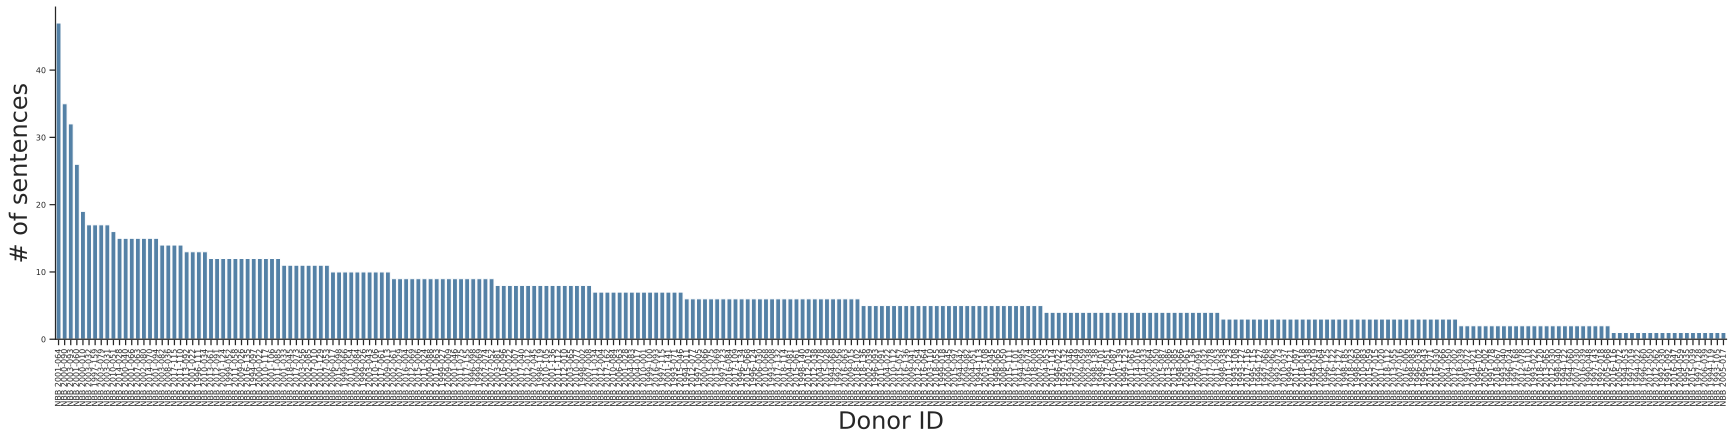

In [26]:
%config InlineBackend.figure_format = 'svg'
sns.set(rc={'figure.figsize':(30,6)},font_scale = 2) #
sns.set_palette("pastel")
sns.set_style("ticks")

## NBB nr frequency df
sentences_per_donor = pd.DataFrame(df['NBB_nr'].value_counts())
sentences_per_donor['x'] = sentences_per_donor.index
sentences_per_donor.columns = ['nr_sentences','NBB_nr']

## plot
ax = sns.barplot(x="NBB_nr", y="nr_sentences", data=sentences_per_donor, color='steelblue')
plt.xlabel("Donor ID")
plt.ylabel("# of sentences")

plt.tick_params(labelsize=8)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
plt.xticks(rotation=90)
# plt.savefig(save_path_figures + "/training_data_sentences_per_donor_{}.png".format(date.today()),
#             bbox_inches="tight",dpi=600)
# plt.savefig(save_path_figures + "/training_data_sentences_per_donor_{}.pdf".format(date.today()),
#             bbox_inches="tight",dpi=600)
# plt.show()